<h2> NAMA: Muhammad Arun Nugraha </h2>
<h2> NIM : 09011181823003 </h2>

<h2> Handwritten Recognition Dengan Menggunakan Artificial Neural Network <h2>

<h3> Artificial Neural Network (ANN) </h3>

Mengartikan dari namanya, artificial neural network (ANN) merupakan jaringan saraf tiruan. Hal ini benar adanya, namun tidak secara harfiah – sistem ini tidak memiliki bentuk fisik seperti neuron-neuron beserta dendritnya, melainkan terinspirasi dari cara kerja sistem otak dan saraf manusia, dan merupakan usaha untuk mengimitasinya dengan serangkaian silikon dan perkabelan.

Pada hal ini, ANN digunakan untuk membaca atau mendeteksi angka yang telah dibuat pada dataset. adapun library yang dibutuhkan adalah sebagai berikut:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import os

Numpy : Digunakan untuk membentuk objek N-dimensional array.

matplotlib : digunakan untuk memvisualisasikan grafik atau gambar yang akan ditampilkan

struct : Digunakan untuk keperluan penyimpanan data binary

os :Digunakan akan program pada python dapat berinteraksi pada sistem operasi

Setelah modul dan library telah di import, maka selanjutnya adalah membuat program untuk membaca dataset yang telah dibuat atau didownload. Adapun programnya adalah sebagai berikut:

In [4]:
def read(dataset="training", path=None):

    if path == None:
        path = '/datasets/MNIST'
        if not os.path.isdir(path):
            path = './datasets/MNIST'
    if not os.path.isdir(path):
        raise ValueError("tidak dapat membaca dataset pada '%s'" % path)

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset harus dari 'testing' atau 'training'")

    
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    img = np.moveaxis(img, 0, -1)
    lbl = lbl.astype(int)

    return img, lbl

pada program diatas, diketahui fungsi 'read' digunakan untuk membaca datasetnya.

setelah program untuk membaca dataset dibuat, maka kita tinggal memanggil program tersebut dan memulai eksekusi membaca datanya.

In [5]:
xtrain, ltrain = read(dataset="training")
xtest, ltest = read(dataset="testing")
print(f'Besar training datanya adalah {xtrain.shape[1]}')
print(f'Besar dimensinya adalah {xtrain.shape[0]}.')
print(f'Bentuk dari images sebesar {xtrain.shape} dan bentuk dari labels sebesar {ltrain.shape}.')

Besar training datanya adalah 60000
Besar dimensinya adalah 784.
Bentuk dari images sebesar (784, 60000) dan bentuk dari labels sebesar (60000,).


Pada program diatas, diketahui bahwa training data sebesar 60000, dan dimensinya sebesar 784. Sedangkan bentuk dari images adalah(784,60000)dan bentuk dari labels sebesar(60000).

<h3> Menormalisasi Data </h3>

Selanjutnya adalah menormalisasi input data dan mentranslate labelnya agar dapat dijalankan, dengan program sebagai berikut:

In [6]:
def normalize(x):
    x = x.astype(np.float32)
    MAX = np.max(x)
    MIN = np.min(x)
    x = -1 + 2 * ( x - MIN) / ( MAX - MIN)
    return x

def onehot2label(a):
    lbl = a.argmax(axis=0)
    return lbl

def label2onehot(label):
    a = np.zeros((label.max() + 1, label.size))
    a[[ind for ind in label], np.arange(label.size)] = 1
    return a

xtrain = normalize(xtrain)
xtest = normalize(xtest)
dtrain = label2onehot(ltrain)
dtest = label2onehot(ltest)
print('bentuk dari one-hot codes adalah {}.'.format(np.shape(dtrain)))

bentuk dari one-hot codes adalah (10, 60000).


Pada program diatas, diketahui bahwa bentuk dari one-hot codes adalah (10,60000)

<h3> Softmax, ReLU,dan loss Metric </h3>

selanjutnya adalah membuat fungsi Softmax, ReLU,dan Loss metric.

Rumus Softmax:

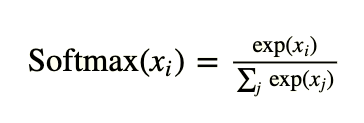

adapun programnya adalah sebagai berikut:


In [7]:
def softmax(b):
    a = np.exp(b - b.max(axis=0))
    return a / np.sum(a,axis=0)

def softmaxp(b, e):
    g = softmax(b)
    return g * e - np.sum(g * e, axis=0) * g

def relu(b):
    return np.maximum(b,0)
    
def relup(b, e):
    return (b > 0) * 1 * e

def eval_loss(y, a):
    return np.sum( -a * np.log(y)) / y.size

def eval_perfs(y, label):
    dlbl = label2onehot(label)
    pred = np.max( y * dlbl, axis=0)
    comp = np.max( y, axis=0)
    return np.sum(pred != comp) / np.size(label)

<h3> Struktur </h3>

Selanjutnya adalah membuatkan strukturnya. Dalam hal ini, Hidden layernya ada 2, yaitu w dan z. Sedangkan Node yang digunakan sebesar 512. Setelah itu, digunakan back propagation, dimana forward digunakan untuk menghitung error, dan backward digunakan untuk menghitung bobot yang dihasilkan error, dan dilakukan secara berulang.

proses back propagation:

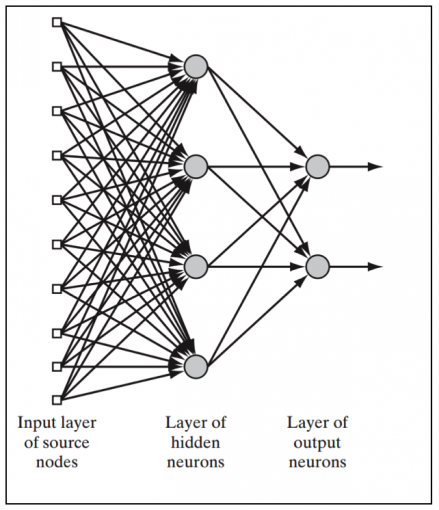

adapun programnya adalah sebagai berikut:

In [8]:
def init_fc(dim_in, dim_out, internal=[512]):
    layer = len(internal)+1
    internal.insert(0, dim_in)
    internal.append(dim_out)
    W = []
    z = []
    for i in range(layer):
        W_add = np.random.randn(internal[i+1], internal[i]) / np.sqrt((internal[i]+1.)/2.)
        z_add = np.random.randn(internal[i+1], 1) / np.sqrt((internal[i]+1.)/2.)
        W.append(W_add)
        z.append(z_add)
    return W,z

def forward(x, W, z):
    layer = len(W)
    h = x
    cache = []
    for i in range(layer):
        b = W[i] @ h + z[i]
        cache.append(b)
        h = relu(b)
    y = softmax(cache[-1])
    return y,cache

def backward(x, a, W, z, gamma=.05):
    layer = len(W)
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    y,cache = forward(x, W, z)
    # Error evaluation
    e = -a / y
    # Backward phase
    delta = [softmaxp(cache[-1], e)]
    for i in range(layer-1,0,-1):
        add = relup(cache[i-1], W[i].T @ delta[-1])
        delta.append(add)
    delta = delta[::-1]
    # Gradient update
    W[0] = W[0] - gamma * delta[0] @ x.T
    z[0] = z[0] - gamma * delta[0].sum( axis=1, keepdims=True)
    for i in range(1,layer):
        W[i] = W[i] - gamma * delta[i] @ cache[i-1].T
        z[i] = z[i] - gamma * delta[i].sum( axis=1, keepdims=True)
    return W,z

<h3> Melatih data </h3>

Selanjutnya dataset dilatih. Pada hal ini digunakan teknik batches. Data yang akan dilatih berjumlah 10. Adapun programnya adalah sebagai berikut:

1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
10 10
Final Loss: 0.0022675725840804427
persentase akhir pada Training errors: 0.72 %


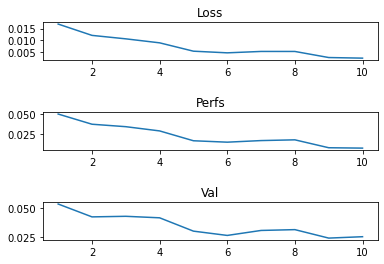

In [10]:
def backprop_batch(x, a, v, a_v, W, z, T=10, B=100, gamma=.05):
    N = x.shape[1]
    NB = int((N+B-1)/B)
    label = onehot2label(a)
    label_v = onehot2label(a_v)
    loss = []
    perfs = []
    val = []
    for t in range(T):
        print(t+1,T)
        shuffled_indices = np.random.permutation(range(N))
        for k in range(NB):
            batch_indices = shuffled_indices[B*k:min(B*(k+1), N)]
            W,z = backward(x[:,batch_indices], a[:,batch_indices], W, z, gamma)
            
        y,_ = forward(x, W, z)
        y_v,_ = forward(v, W, z)
        loss.append(eval_loss(y,a))
        perfs.append(eval_perfs(y,label))
        val.append(eval_perfs(y_v,label_v))
        
    print ("Final Loss:", loss[-1])
    print (f'persentase akhir pada Training errors: {100*perfs[-1]:.2f} %')
    axis_x = np.arange(1,len(loss)+1)
    plt.subplot(5,1,1)
    plt.plot(axis_x,loss)
    plt.title('Loss')
    plt.show
    plt.subplot(5,1,3)
    plt.plot(axis_x,perfs)
    plt.title('Perfs')
    plt.show
    plt.subplot(5,1,5)
    plt.plot(axis_x,val)
    plt.title('Val')
    plt.show
    return W,z

dim_in = xtrain.shape[0]
internal = [512,256,128,64,32]
dim_out = dtrain.shape[0]
W,z = init_fc(dim_in, dim_out, internal)
W,z = backprop_batch(xtrain, dtrain, xtest, dtest, W, z, T=10, B=100, gamma=.05)

Pada program diatas, dapat diketahui bahwa Final loss dari data yang dilatih adalah 0.002179885873232097, dan persentase akhir pada training errors adalah 0.66%.

<h3> Hasil </h3>

Selanjutnya adalah menunjukkan hasil outputnya. Pada hal ini dibuatkan program untuk menunjjukan output yang akan ditunjukkan. Adapun programnya adalah sebagai berikut:

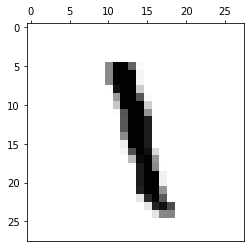

Prediksi angka yang keluar adalah: 1


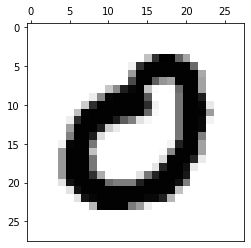

Prediksi angka yang keluar adalah: 0


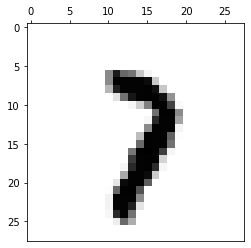

Prediksi angka yang keluar adalah: 7


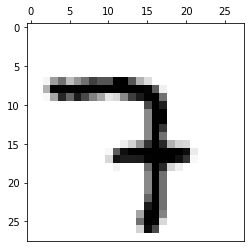

Prediksi angka yang keluar adalah: 7


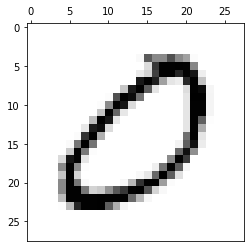

Prediksi angka yang keluar adalah: 0


In [8]:
def show(image):
   
    rows = 28
    cols = 28
    if image.shape[0] != rows * cols and image.shape[0] * image.shape[1] != rows * cols:
        raise "the input is not an MNIST image."
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    image = image.reshape(rows, cols)
    imgplot = ax.imshow(image, cmap=plt.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()
    
indcies = range(700,705)
image=xtest[:, indcies]
a,_ = forward(image,W,z)
label = onehot2label(a)
for i,ind in enumerate(indcies):
    show(xtest[:, ind])
    print('Prediksi angka yang keluar adalah:', label[i])

Pada program diatas, fungsi 'show' digunakan untuk membaca output yang akan ditampilkan. Untuk menentukan output yang ditampilkan,maka dibuatkan 'indcies'. Pada program diatas, range pada indcies adalah (700,705). Maksud dari range tersebut adalah program membaca atau mendeteksi angka dari index 700, dan '705' itu jumlah angka yang di keluarkan, yaitu 5. jadi, outputnya adalah 1,0,7,7,0.